In [ ]:
import os
import sys
import time
import pickle as pk
from typing import Union, Tuple
from collections import OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.autograd import grad
from torch.nn import Parameter
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchsummary import summary

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_mnist_loaders(batch_size):
  train_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
  train_loader = DataLoader(train_data, batch_size=len(train_data))
  batch = next(iter(train_loader))
  x, y = batch
  mean, std = torch.mean(x), torch.std(x)
  transform  = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean, std)
  ])
  
  train_data = datasets.MNIST('data', train=True, download=True, transform=transform)
  test_data = datasets.MNIST('data', train=False, download=True, transform=transform)

  yield DataLoader(train_data, batch_size=batch_size, shuffle=True)
  yield DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [ ]:
batch_size = 64
train_loader, test_loader = get_mnist_loaders(batch_size)

In [ ]:
class SkipConnection(nn.Module):
  def __init__(self, body):
    nn.Module.__init__(self)
    self.body = body
  
  def forward(self, x):
    y = self.body(x)
    return x + y

In [ ]:
class ConvActNorm(nn.Sequential):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
    nn.Sequential.__init__(self, OrderedDict([
      ('conv', nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)),
      ('relu', nn.LeakyReLU()),
      ('bnorm', nn.BatchNorm2d(out_channels)),
    ]))

In [ ]:
class ResNet(nn.Module):
  def __init__(self, height, width, n):
    nn.Module.__init__(self)
    layers = []
    layers.append(('can_in', ConvActNorm(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)))
    chn = 16
    # layers.append(('conv_in', nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)))
    # layers.append(('relu_in', nn.LeakyReLU()))
    # layers.append(('bnorm_in', nn.BatchNorm2d(16)))
    for i in (0, 1, 2):
      for j in range(2 * n):
        first_half = nn.Sequential(
            ConvActNorm(chn, 16 * 2 ** i, 3, 1, 1),
            ConvActNorm(16 * 2 ** i, 16 * 2 ** i, 3, 1, 1)
        )
        if chn == 16 * 2 ** 1 and (j != 0 or i == 0):
          first_half = SkipConnection(first_half)
        chn = 16 * 2 ** i
        layers.append((f'firsthalf_{i}_{j}', first_half))
        is_last = j == 2 * n - 1
        second_half = nn.Sequential(
            ConvActNorm(chn, chn, 3, 1, 1),
            ConvActNorm(chn, chn, 3, 2 if is_last else 1, 1)
        )
        if not is_last:
          second_half = SkipConnection(second_half)
        else:
          height = (height - 1) // 2 + 1
          width = (width - 1) // 2 + 1
        layers.append((f'secondhalf_{i}_{j}', second_half))
    self.body = nn.Sequential(OrderedDict(layers))
    neck_count = chn * height * width
    self.head = nn.Sequential(
        nn.Linear(neck_count, 10),
        nn.Softmax(1)
    )
    self.neck_count = neck_count
  
  def forward(self, x):
    y = self.body(x)
    return self.head(y.reshape([-1, self.neck_count]))



In [ ]:
def train(
    model: nn.Module, 
    optimizer: optim.Optimizer, 
    data: Union[DataLoader, Tuple[DataLoader]], 
    max_epochs: int, 
    cuda=True):
  
  use_test = False
  if isinstance(data, DataLoader):
    train_loader = data
  elif isinstance(data, tuple):
    if len(data) == 2:
      train_loader, test_loader = data
      if not isinstance(train_loader, DataLoader):
        raise TypeError(f'Expected 1st entry of type DataLoader, but got {type(train_loader)}!')
      if not isinstance(test_loader, DataLoader):
        raise TypeError(f'Expected 2nd entry of type DataLoader, but got {type(test_loader)}!')
      use_test = True
    else:
      raise ValueError(f'Expected tuple of length 2, but got {len(data)}!')
  
  
  criterion = nn.CrossEntropyLoss()
  model.train()
  losses = []
  batch_total = len(train_loader)
  train_accs = dict()
  test_accs = dict()

  for epoch in range(max_epochs):
    samples_total = 0
    samples_correct = 0
    for batch_idx, batch in enumerate(train_loader):
      x, y = batch
      if cuda:
        x, y = x.cuda(), y.cuda()
      output = model(x)
      loss = criterion(output, y)
      loss.backward()
      optimizer.step()
      
      yhat = torch.argmax(output, dim=1)

      samples_total += len(y)
      samples_correct += torch.sum(yhat == y)
      losses.append(loss.item())


      if batch_idx % 50 == 0 or batch_idx == batch_total - 1:
        acc = float(samples_correct) / float(samples_total)
        train_accs[epoch + batch_idx / batch_total] = acc

        if use_test:
          model.eval()

          test_x, test_y = next(iter(test_loader))
          if cuda:
            test_x, test_y = test_x.cuda(), test_y.cuda()
          test_output = model(test_x)
          test_loss = criterion(test_output, test_y)

          test_yhat = torch.argmax(test_output, dim=1)
          test_acc = float(torch.sum(test_yhat == test_y)) / float(len(test_y))
          test_accs[epoch + batch_idx / batch_total] = test_acc
          
          model.train()

          sys.stdout.write(f'\rEpoch: {epoch}/{max_epochs} Step: {batch_idx}/{batch_total} Loss: {loss.item():.6f} Acc: {acc:.2%} Test loss: {test_loss:.6f} Test acc: {test_acc:.2%}')
        else:
          sys.stdout.write(f'\rEpoch: {epoch}/{max_epochs} Step: {batch_idx}/{batch_total} Loss: {loss.item():.6f} Acc: {acc:.2%}')

  return losses, train_accs, test_accs

In [ ]:
def validate(model: nn.Module, data: DataLoader, cuda=True):
  criterion = nn.CrossEntropyLoss()
  losses = []
  correct_samples = 0
  total_samples = 0
  for x, y in data:
      if cuda:
        x, y = x.cuda(), y.cuda()
      output = model(x)
      loss = criterion(output, y)
      yhat = torch.argmax(output, dim=1)
      losses.append(loss.item())
      correct_samples += torch.sum(yhat == y)
      total_samples += len(y)

  mean_losses = np.mean(losses)
  acc = float(correct_samples) / float(total_samples)
  print(f'Validation complete! Validation loss: {mean_losses:.6f}, Validation accuracy: {acc:.2%}')

  return mean_losses, acc

In [ ]:
res_net = ResNet(28, 28, 3)
summary(res_net, input_size=(1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
         LeakyReLU-2           [-1, 16, 28, 28]               0
       BatchNorm2d-3           [-1, 16, 28, 28]              32
            Conv2d-4           [-1, 16, 28, 28]           2,320
         LeakyReLU-5           [-1, 16, 28, 28]               0
       BatchNorm2d-6           [-1, 16, 28, 28]              32
            Conv2d-7           [-1, 16, 28, 28]           2,320
         LeakyReLU-8           [-1, 16, 28, 28]               0
       BatchNorm2d-9           [-1, 16, 28, 28]              32
           Conv2d-10           [-1, 16, 28, 28]           2,320
        LeakyReLU-11           [-1, 16, 28, 28]               0
      BatchNorm2d-12           [-1, 16, 28, 28]              32
           Conv2d-13           [-1, 16, 28, 28]           2,320
        LeakyReLU-14           [-1, 16,

In [ ]:
train_info = {}

In [ ]:
%%time
n = 1
model = ResNet(28, 28, n).cuda()
opt = optim.Adam(model.parameters(), lr=1e-3)
train_info[n] = train(model, opt, tuple(get_mnist_loaders(64)), 10)
model1 = model

Epoch: 9/10 Step: 937/938 Loss: 1.711151 Acc: 72.19% Test loss: 1.726776 Test acc: 73.44%CPU times: user 4min 42s, sys: 1.1 s, total: 4min 43s
Wall time: 4min 44s


In [ ]:

%%time
n = 2
model = ResNet(28, 28, n).cuda()
opt = optim.Adam(model.parameters(), lr=1e-3)
train_info[n] = train(model, opt, tuple(get_mnist_loaders(64)), 10)
model2 = model

Epoch: 9/10 Step: 937/938 Loss: 2.367401 Acc: 9.89% Test loss: 2.383026 Test acc: 7.81%CPU times: user 8min, sys: 1.23 s, total: 8min 2s
Wall time: 8min 3s


In [ ]:

%%time
n = 3
model = ResNet(28, 28, n).cuda()
opt = optim.Adam(model.parameters(), lr=1e-3)
train_info[n] = train(model, opt, tuple(get_mnist_loaders(64)), 10)
model3 = model

Epoch: 9/10 Step: 937/938 Loss: 2.398651 Acc: 10.22% Test loss: 2.304901 Test acc: 15.62%CPU times: user 11min 16s, sys: 8.57 s, total: 11min 24s
Wall time: 11min 26s


In [ ]:
with open('train_info.pth', 'wb') as f:
  pk.dump(train_info, f)

In [ ]:
colors = plt.cm.tab20(np.linspace(0, 1, 20))

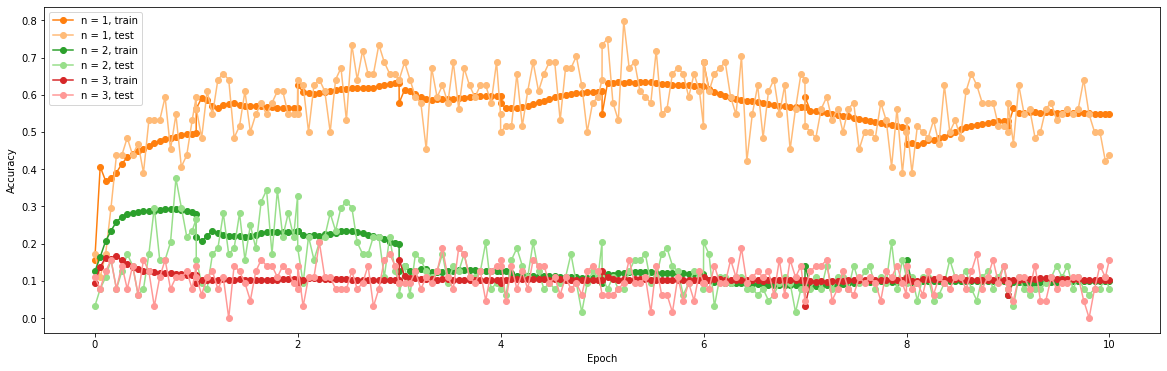

In [ ]:
plt.figure(figsize=(20, 6))
for n, info in train_info.items():
  _, train_accs, test_accs = info
  plt.plot(*zip(*train_accs.items()), '-o', color=colors[2 * n], label=f'n = {n}, train')
  plt.plot(*zip(*test_accs.items()), '-o', color=colors[2 * n + 1], label=f'n = {n}, test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

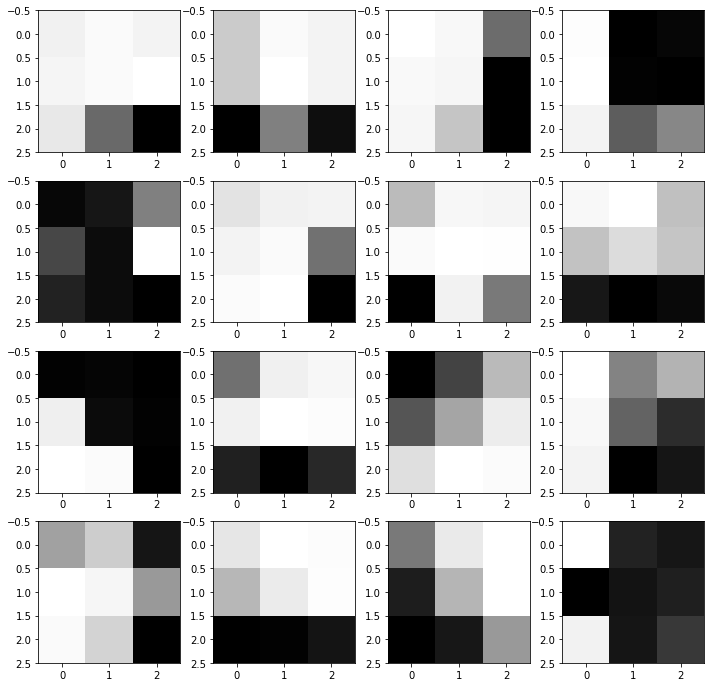

In [ ]:
kernels = model1.body.can_in.conv.weight.cpu().detach().numpy()
plt.figure(figsize=(12, 12))
for k in range(kernels.shape[0]):
  plt.subplot(4, 4, k + 1)
  plt.imshow(kernels[k][0], cmap='gray')

These kernels seem to detect digit borders oriented in different directions.

In [75]:
def mse4d(y1, y2):
  d = y2 - y1
  shp = d.shape
  return torch.einsum('ijkl,ijkl->', d, d) / (shp[0] * shp[1] * shp[2] * shp[3])

In [78]:
def mse4d_dict_hook_create(d, name):
  def hook(model, x, y):
    d[name] = mse4d(x[0], y)
  return hook

In [82]:
hooks = dict()
mses = dict()
for k, v in model1.body.named_children():
  if type(v) == SkipConnection:
    hooks[k] = v.register_forward_hook(mse4d_dict_hook_create(mses, k))

In [87]:
inimg = tuple(next(iter(tuple(get_mnist_loaders(64))[1])))[0].cuda()
model1(inimg)
pass

In [85]:
for k, v in mses.items():
  print(f'{k}:\tMSE = {v}')

secondhalf_0_0:	MSE = 91.04904174804688
secondhalf_1_0:	MSE = 101.27399444580078
firsthalf_1_1:	MSE = 70.23033905029297
secondhalf_2_0:	MSE = 54.97813034057617


The layers do not seem to be identity.

In [86]:
for v in hooks.values():
  v.remove()

For the current configuration and checked $n$, deeper networks are worse. One of possible causes for the bad results may be too small number of neurons in one of the layers.